In [1]:
import torch
import torch.nn as nn
from torch import optim
import pandas as pd
import matplotlib.pyplot as plt

## Input이 1차원인 경우

In [2]:
class LSTMcell_dim1(nn.Module):
    def __init__(self):
        super(LSTMcell_dim1, self).__init__()
        self.xi = nn.Linear(1,1)
        self.hi = nn.Linear(1,1)
        self.xg = nn.Linear(1,1)
        self.hg = nn.Linear(1,1)
        self.xf = nn.Linear(1,1)
        self.hf = nn.Linear(1,1)
        self.xo = nn.Linear(1,1)
        self.ho = nn.Linear(1,1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, xt, ht_1, ct_1):
        xt = torch.flatten(xt)      # 1차원으로 조정
        ht_1 = torch.flatten(ht_1)  # 1차원으로 조정
        it = self.sigmoid(self.xi(xt) + self.hi(ht_1))
        gt = self.tanh(self.xg(xt) + self.hg(ht_1))
        ft = self.sigmoid(self.xf(xt) + self.hg(ht_1))
        ct = ft*ct_1 + it*gt
        ot = self.sigmoid(self.xo(xt) + self.ho(ht_1))
        ht = ot*self.tanh(ct)
        return ht, ct

In [5]:
class LSTMmodel_dim1(nn.Module):
    def __init__(self):
        super(LSTMmodel_dim1, self).__init__()
        self.lstm = LSTMcell_dim1()
        self.fc = nn.Linear(1,1)

    def forward(self,x):
        cn = torch.ones(1,1, dtype=torch.float32)
        hn = torch.ones(1,1, dtype=torch.float32)
        outs_list = []
        for seq in range(len(x)):
            hn, cn = self.lstm(x[seq], hn, cn)
            outs_list.append(self.fc(hn))
        outs = torch.cat(outs_list, 0)
        return outs

    def predict(self,x,times):
        cn = torch.ones(1,1, dtype=torch.float32)
        hn = torch.ones(1,1, dtype=torch.float32)
        prediction = []
        for seq in range(len(x)):
            hn, cn = self.lstm(x[seq], hn, cn)
            k = self.fc(hn)
            prediction.append(k)
        for i in range(times):
            hn, cn = self.lstm(k,hn,cn)
            k = self.fc(hn)
            prediction.append(k)
        return prediction

In [6]:
x = pd.read_csv('international_airline_passengers.csv', index_col=0, header=None)
x.columns = ['Passengers']

In [ ]:
train = x[:120]
test = x[120:]

train = torch.flatten(torch.tensor(train.values, dtype=torch.float32))   # 값만 가져오기
test = torch.flatten(torch.tensor(test.values, dtype=torch.float32))   # 값만 가져오기

In [ ]:
lstm = LSTMmodel_dim1()
loss_ftn = nn.MSELoss()
optimizer = torch.optim.SGD(lstm.parameters(), lr=0.01)

epochs = 200
history = []

for i in range(epochs):
    out = lstm(train)
    out = out.flatten()
    loss = loss_ftn(train[1:], out[:-1])   # out이 train의 다음을 예측하니까 !
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    history.append(loss.item())

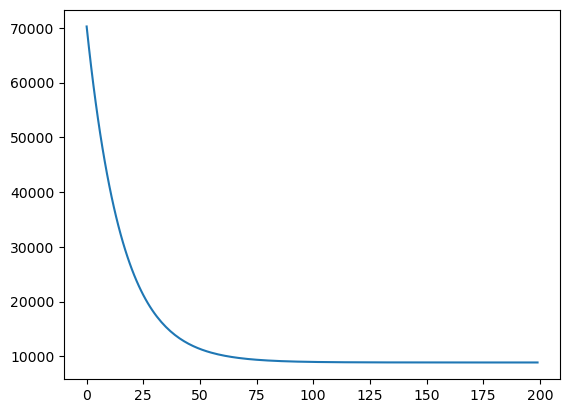

In [ ]:
plt.plot(history)

In [ ]:
pred = lstm.predict(train,24)  # 예상대로 일직선 나옴

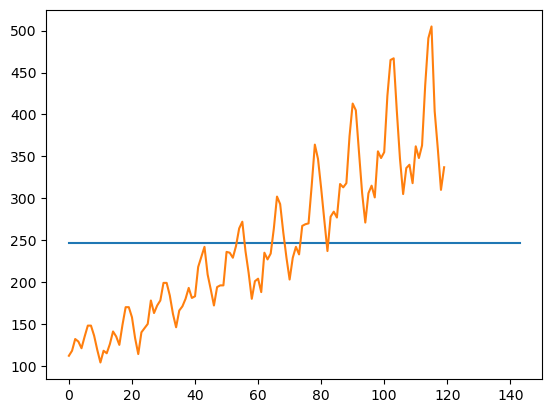

In [ ]:
plt.plot(torch.tensor(pred).detach().numpy())
plt.plot(train)
plt.show()

In [ ]:
torch.mean(train)

tensor(245.9083)

## Input이 multi variant라면?

In [ ]:
class LSTMcell(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()